In [1]:
from models import *
from DScontrol import *
import matplotlib.pyplot as plt
import warnings
from skimage.transform import rotate, resize, hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.filters import gabor, threshold_triangle
from skimage.morphology import disk

In [2]:
#edge = EdgeBlur(15, 5, 15, 1, 5)
#gabor = FourierGabor(5, 5, 5)

predict = {
    #'EdgeBlur':[],
    #'EdgeBlur_error':[],
    'FourierGabor':[],
    'FourierGabor_error':[]
}
total = len(DS)
for i, filename in enumerate(DS.filename):
    image = get(filename)
    
    '''with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        area, error = edge.predict(image)
        predict['EdgeBlur'].append(area)
        predict['EdgeBlur_error'].append(error)
    area, error = gabor.predict(image)
    predict['FourierGabor'].append(area)
    predict['FourierGabor_error'].append(error)'''
    
    img = rgb2gray(image)
    
    _, angles, _ = hough_line_peaks(*hough_line(canny(img), np.linspace(-np.pi/2, np.pi/2, 500)))
    slopes = np.degrees(angles + np.pi/2)
    slope_values = np.unique(slopes)
    probs = np.array([np.sum(slopes == val)/len(slopes) for val in slope_values])
    img_slope = slope_values[probs == probs.max()][0]
    img = rotate(img, img_slope, mode='reflect')
    
    Fx = np.apply_along_axis(pixel_scale_1d, 0, image)
    Fy = np.apply_along_axis(pixel_scale_1d, 1, image)
    fx, fy = np.median(Fx[Fx > 0.025]), np.median(Fy[Fy > 0.025])
    
    xreal, ximag = gabor(img, fx, 0)
    yreal, yimag = gabor(img, fy, np.pi/2)
    #filtered = nd.minimum_filter(xreal**2 + ximag**2 + yreal**2 + yimag**2, (10, 10))
    filtered = nd.median_filter(nd.minimum_filter(xreal**2 + ximag**2 + yreal**2 + yimag**2, footprint=disk(5)), footprint=disk(5))

    mask = filtered < threshold_triangle(filtered, nbins=50)
    #mask = filtered < threshold_minimum(filtered)
    mask = nd.binary_opening(mask, iterations=15)
    #mask = nd.binary_closing(mask, iterations=10)
    mask = nd.binary_dilation(mask, iterations=1)
    #mask = rotate(mask, -img_slope)
    
    predict['FourierGabor'].append(np.sum(mask)*fx*fy)

    print(f'{i+1}/{total}|{(i/total*100):.2f}%', end='\r')

In [40]:
ds = pd.concat([DS, pd.DataFrame(predict)], axis=1)
ds

,filename,area,FourierGabor,FourierGabor_error
0,0.jpg,100.473,105.027969,0.227643
1,1.jpg,127.880,135.908127,0.023820
2,2.jpg,161.820,171.705444,0.062668
3,3.jpg,190.003,181.720215,0.463668
4,4.jpg,22.713,21.627853,0.009092
...,...,...,...,...
350,350.jpg,98.599,100.750671,0.056719
351,351.jpg,98.599,100.099060,0.122426
352,352.jpg,98.599,100.805054,0.090786
353,353.jpg,98.599,100.429565,0.113918


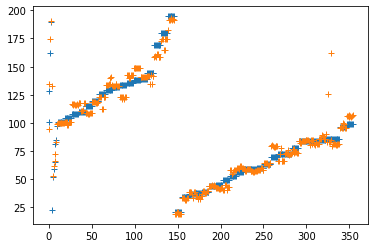

In [3]:
plt.plot(DS.area, '+')
plt.plot(predict['FourierGabor'], '+')
#plt.plot(ds.EdgeBlur, '+')
plt.show()

In [4]:
DS['gabor'] = predict['FourierGabor']

In [5]:
DS['disp'] = DS.area - DS.gabor

In [6]:
(np.abs(DS.disp)/DS.area*100).describe()

count    355.000000
mean       6.160079
std       26.272482
min        0.021035
25%        1.419522
50%        3.690554
75%        6.789706
max      485.821277
dtype: float64